#Step 1: Video library (10 points)
Write a python API that will download the video and its closed captions from youtube. Make sure to document how one can use your API. Use this to download the following videos from youtube along with their captions:

In [ ]:
import os
from pytube import YouTube
from youtube_transcript_api import YouTubeTranscriptApi

def download_video(link, output_path='.'):
    """
    Download a YouTube video from the provided link.

    Args:
    - link (str): The URL of the YouTube video.
    - output_path (str): The path where the video will be saved. Default is the current directory.
    """
    try:
        youtube_object = YouTube(link)
        video_stream = youtube_object.streams.get_highest_resolution()
        video_title = youtube_object.title
        output_file = video_stream.download(output_path)
        new_filename = os.path.join(output_path, f"{video_title}.mp4")
        os.rename(output_file, new_filename)
        print(f"Download completed successfully for: {link}")
    except Exception as e:
        print(f"An error occurred while downloading the video for {link}: {str(e)}")

def download_captions(video_id, output_path='.'):
    """
    Download closed captions for a YouTube video.

    Args:
    - video_id (str): The ID of the YouTube video.
    - output_path (str): The path where the captions will be saved. Default is the current directory.
    """
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        captions_file = os.path.join(output_path, f"{video_id}_captions.txt")
        with open(captions_file, "w", encoding='utf-8') as f:
            for segment in transcript:
                f.write(f"{segment['text']}\n")
        print(f"Captions downloaded successfully for video ID: {video_id}")
    except Exception as e:
        print(f"An error occurred while downloading captions for video ID {video_id}: {str(e)}")

def extract_video_id(link):
    """
    Extract the video ID from a YouTube link.

    Args:
    - link (str): The URL of the YouTube video.

    Returns:
    - str: The video ID.
    """
    try:
        return link.split("v=")[1].split("&")[0]
    except IndexError:
        raise ValueError("Invalid YouTube URL format")

def download_video_and_captions(video_links, output_path='.'):
    """
    Download both the video and its closed captions from YouTube.

    Args:
    - video_links (list): List of YouTube video URLs.
    - output_path (str): The path where the videos and captions will be saved. Default is the current directory.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for link in video_links:
        try:
            video_id = extract_video_id(link)
            download_video(link, output_path)
            download_captions(video_id, output_path)
        except Exception as e:
            print(f"An error occurred with the video link {link}: {str(e)}")

video_links = [
    'https://www.youtube.com/watch?v=wbWRWeVe1XE',
    'https://www.youtube.com/watch?v=FlJoBhLnqko',
    'https://www.youtube.com/watch?v=Y-bVwPRy_no'
]

output_path = '/content/downloads'
download_video_and_captions(video_links, output_path)

for root, dirs, files in os.walk(output_path):
    for file in files:
        print(os.path.join(root, file))


Download completed successfully for: https://www.youtube.com/watch?v=wbWRWeVe1XE
Captions downloaded successfully for video ID: wbWRWeVe1XE
Download completed successfully for: https://www.youtube.com/watch?v=FlJoBhLnqko
Captions downloaded successfully for video ID: FlJoBhLnqko
Download completed successfully for: https://www.youtube.com/watch?v=Y-bVwPRy_no
Captions downloaded successfully for video ID: Y-bVwPRy_no
/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
/content/downloads/How Green Roofs Can Help Cities | NPR.mp4
/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4
/content/downloads/wbWRWeVe1XE_captions.txt
/content/downloads/FlJoBhLnqko_captions.txt
/content/downloads/Y-bVwPRy_no_captions.txt


#Preprocess the video (15 points)
You can use opencv, ffmpeg, gstreameer, https://pytorchvideo.org/ or any other library to implement the preprocessing steps as shown below:


In [ ]:
import cv2  # OpenCV library for image and video processing
import numpy as np
from tqdm import tqdm  # Used for progress bars during frame processing
import os

def preprocess_video(video_path, output_filename, num_frames=32, resize=(224, 224)):
    """
    Preprocess a video: decode frames, sample frames, resize, scale, normalize, and save as .npy.

    Args:
    - video_path (str): Path to the input video file.
    - output_filename (str): Filename for the output .npy file.
    - num_frames (int): Number of frames to sample from the video. (default is 32).
    - resize (tuple): Target size for resizing frames (width, height). (default is (224, 224)).

    Returns:
    - frames (np.ndarray): Processed frames stacked in a numpy array.
    """
    cap = cv2.VideoCapture(video_path)  # Open video capture object
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total number of frames in the video
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)  # Generate evenly spaced frame indices to sample from

    frames = []
    for idx in tqdm(frame_indices, desc=f"Processing {os.path.basename(video_path)}"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)  # Set frame position
        ret, frame = cap.read()  # Read frame
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frame = cv2.resize(frame, resize)  # Resize frame to specified dimensions
            frame = frame.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
            frames.append(frame)
        else:
            print(f"Warning: Could not read frame at index {idx} from video {video_path}")

    cap.release()  # Release video capture object
    if len(frames) < num_frames:
        print(f"Warning: Not enough frames were read from {video_path}. Expected {num_frames}, got {len(frames)}.")

    frames = np.stack(frames) if frames else np.empty((0, *resize, 3))  # Handle case when no frames are read
    np.save(output_filename, frames)  # Save processed frames as .npy file
    print(f"Processed frames saved to {output_filename}")

    return frames

# List of video paths and corresponding output filenames
video_paths = [
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4",
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4"
]

output_filenames = [
    '/content/downloads/green_roofs_frames.npy',
    '/content/downloads/preschool_frames.npy',
    '/content/downloads/hotter_city_frames.npy'
]

# Ensure output directories exist
for output_filename in output_filenames:
    output_dir = os.path.dirname(output_filename)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

# Process each video and save frames
for video_path, output_filename in zip(video_paths, output_filenames):
    preprocess_video(video_path, output_filename)


Processing Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 49.01it/s]


Processed frames saved to /content/downloads/green_roofs_frames.npy


Processing How Green Roofs Can Help Cities | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 56.52it/s]


Processed frames saved to /content/downloads/preschool_frames.npy


Processing What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4: 100%|██████████| 32/32 [00:00<00:00, 44.62it/s]

Processed frames saved to /content/downloads/hotter_city_frames.npy


Displaying frames from: /content/downloads/green_roofs_frames.npy
Number of frames in /content/downloads/green_roofs_frames.npy: 32


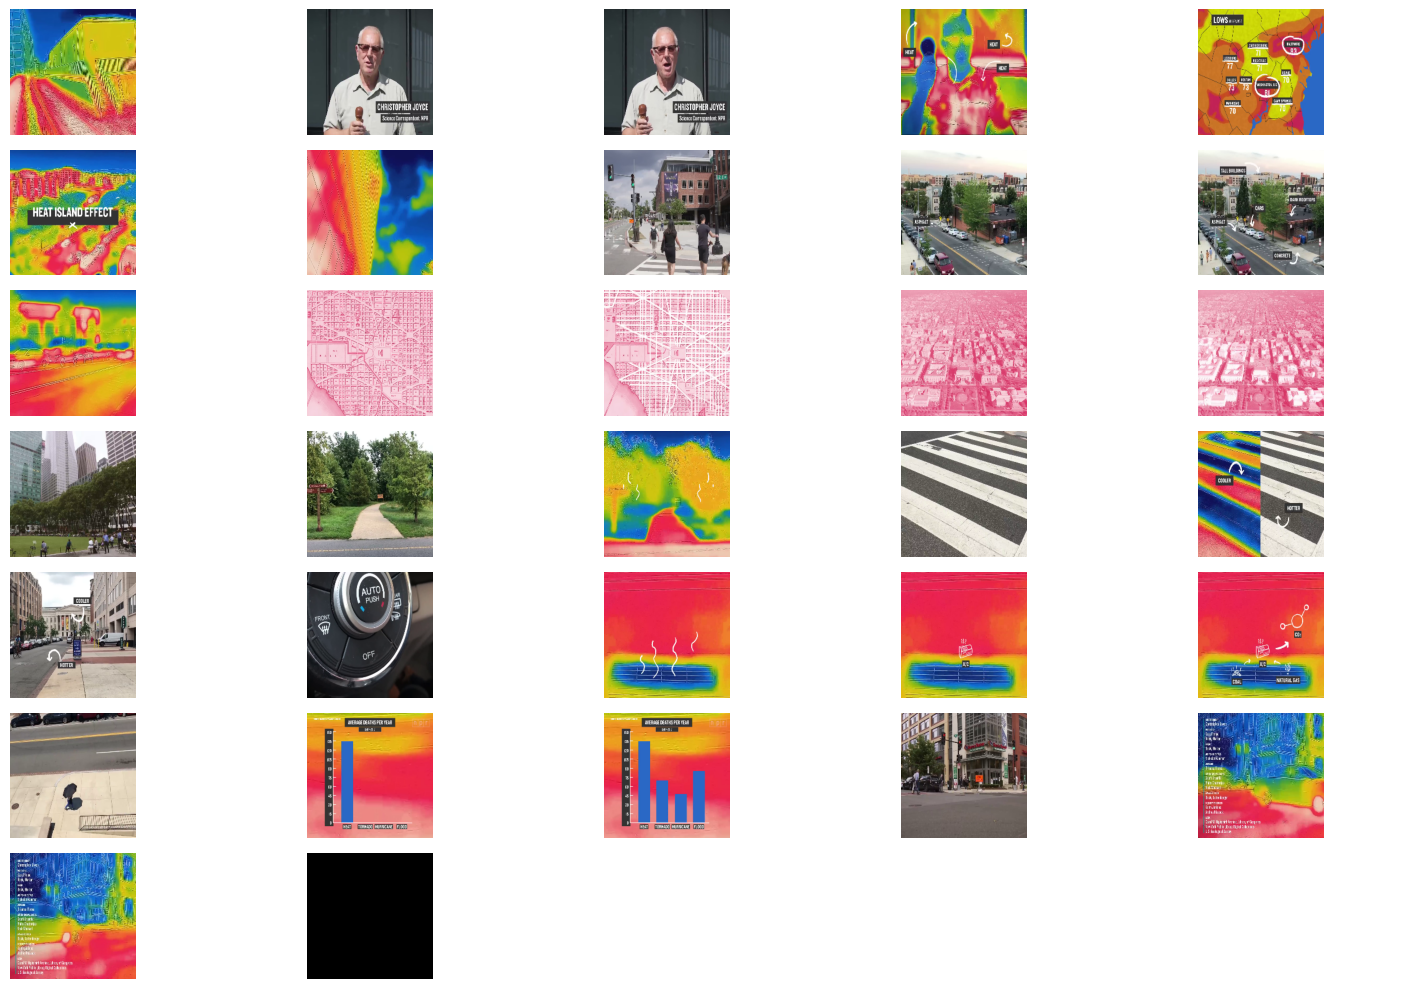

Displaying frames from: /content/downloads/preschool_frames.npy
Number of frames in /content/downloads/preschool_frames.npy: 32


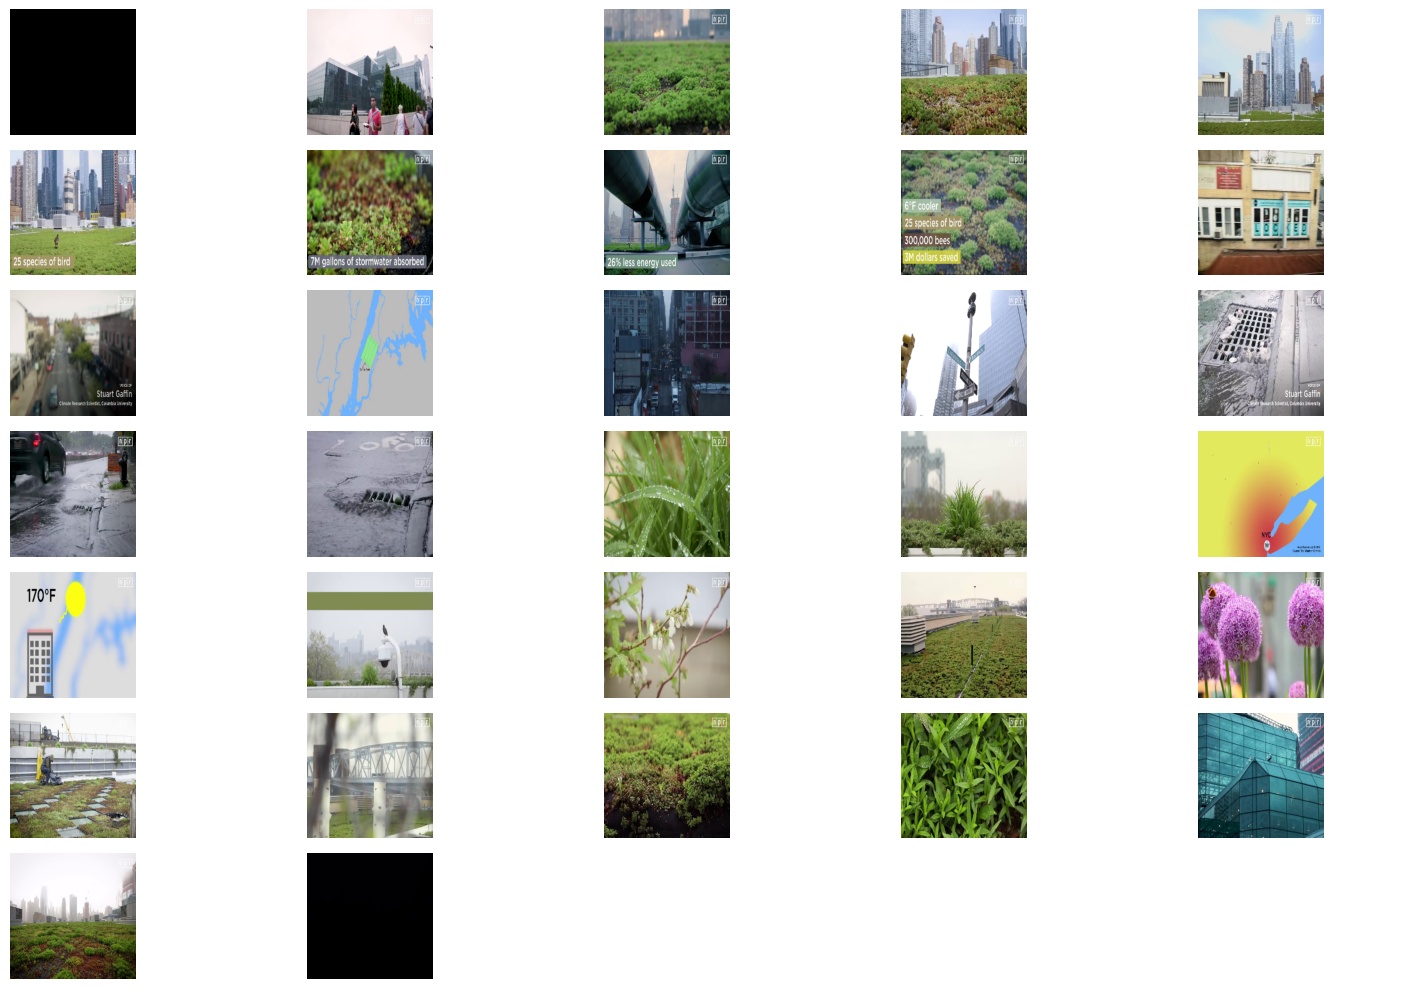

Displaying frames from: /content/downloads/hotter_city_frames.npy
Number of frames in /content/downloads/hotter_city_frames.npy: 32


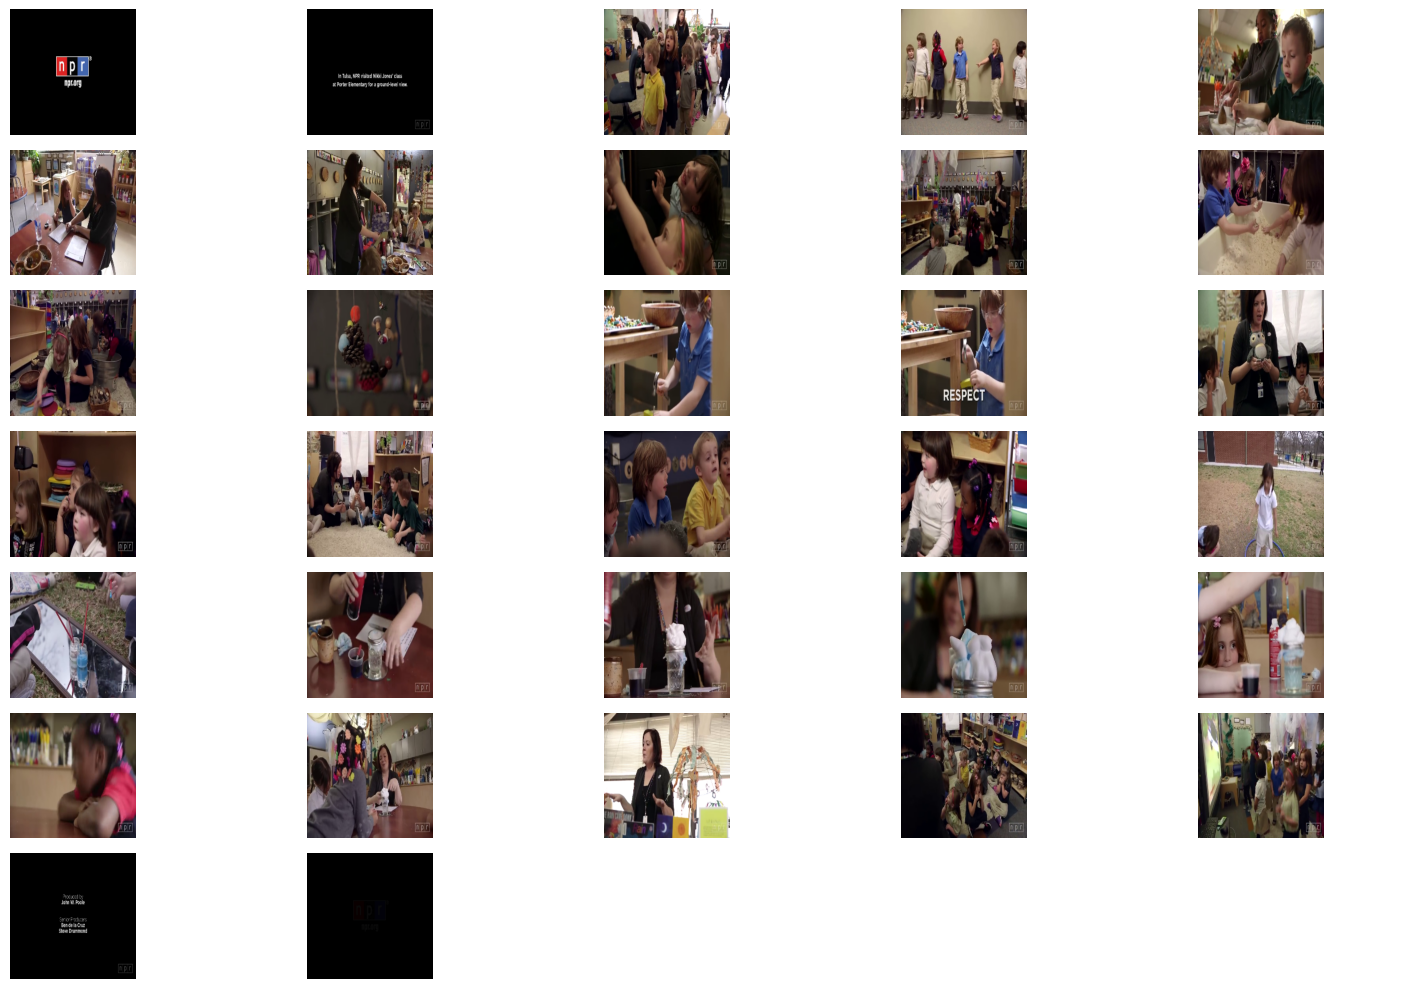

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to load and display frames from .npy file
def display_frames_from_npy(npy_file):
    frames = np.load(npy_file)
    num_frames = frames.shape[0]
    print(f"Number of frames in {npy_file}: {num_frames}")

    # Dynamically adjust the subplot layout
    cols = min(num_frames, 5)  # Show up to 5 frames per row
    rows = (num_frames + cols - 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten() if num_frames > 1 else [axes]

    for i in range(num_frames):
        axes[i].imshow(frames[i])
        axes[i].axis('off')

    for j in range(num_frames, len(axes)):  # Hide any extra subplots
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage to display frames from each .npy file
npy_files = [
    '/content/downloads/green_roofs_frames.npy',
    '/content/downloads/preschool_frames.npy',
    '/content/downloads/hotter_city_frames.npy'
]

for npy_file in npy_files:
    print(f"Displaying frames from: {npy_file}")
    display_frames_from_npy(npy_file)


#Detecting objects (25 points)
Use any of the pretrained object-detectors to detect objects belonging to MS COCO classes. For each video, for each frame where a detection is found, compile and report the results in the following tabular structure :

[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]

In [ ]:
import cv2
import torch
import pandas as pd
import numpy as np
from datetime import timedelta
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# List of video paths
video_paths = [
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4",
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4"
]
results = []

# Process each video
for vidId, video_path in enumerate(video_paths):
    logging.info(f"Processing video {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Error: Could not open video {video_path}")
        continue

    frame_num = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    logging.info(f"Total frames: {total_frames}, FPS: {fps}")

    frame_interval = 10  # Process every 10th frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % frame_interval == 0:
            logging.info(f"Processing frame {frame_num}/{total_frames}")
            timestamp = str(timedelta(seconds=frame_num / fps))

            results_yolo = model(frame)
            detections = results_yolo.pandas().xyxy[0]

            for _, detection in detections.iterrows():
                detectedObjId = detection['class']
                detectedObjClass = detection['name']
                confidence = detection['confidence']
                bbox_info = [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']]

                results.append([
                    vidId, frame_num, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, video_path  # Include video_path
                ])

        frame_num += 1

    cap.release()
    logging.info(f"Finished processing video {video_path}")

# Save results to CSV
df = pd.DataFrame(results, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox info', 'video_path'])
df.to_csv('detection_results.csv', index=False)
logging.info("Detection results saved to detection_results.csv")


/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 237.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 237.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 7.5s, installed 3 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-6-21 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 227MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
WARNING ⚠️ NMS time limit 0.550s exceeded


#2.3 Embedding model (30 points)
Develop a convolutional autoencoder such as the one described here whose input will be all the objects detected in each frame (not the entire frame!), if any. Note : You can downsample the frame rate of your original video to avoid long training/processing times. For a given input image, the autoencoder should output it’s small vector embedding.

Train your autoencoder on the COCO dataset for classes which get detected in the given list of videos.

#Step 1: Extract Detected Objects
First, we need to crop the detected objects from the video frames and resize them to a consistent size.

In [ ]:
import cv2
import torch
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# List of video paths
video_paths = [
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
]

results = []
cropped_objects = []

# Ensure output directories exist
cropped_objects_dir = '/content/cropped_objects'
os.makedirs(cropped_objects_dir, exist_ok=True)

# Process each video
for vidId, video_path in enumerate(video_paths):
    logging.info(f"Processing video {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Error: Could not open video {video_path}")
        continue

    frame_num = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    logging.info(f"Total frames: {total_frames}, FPS: {fps}")

    frame_interval = 10  # Process every 10th frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % frame_interval == 0:
            logging.info(f"Processing frame {frame_num}/{total_frames}")
            timestamp = str(timedelta(seconds=frame_num / fps))

            results_yolo = model(frame)
            detections = results_yolo.pandas().xyxy[0]

            for _, detection in detections.iterrows():
                detectedObjId = detection['class']
                detectedObjClass = detection['name']
                confidence = detection['confidence']
                bbox_info = [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']]

                # Extract and save the detected object
                xmin, ymin, xmax, ymax = map(int, [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']])
                cropped_obj = frame[ymin:ymax, xmin:xmax]
                cropped_obj_resized = cv2.resize(cropped_obj, (64, 64))  # Resize to a consistent shape
                obj_filename = f"{cropped_objects_dir}/video{vidId}_frame{frame_num}_obj{detectedObjId}.jpg"
                cv2.imwrite(obj_filename, cropped_obj_resized)
                cropped_objects.append(cropped_obj_resized)

                results.append([
                    vidId, frame_num, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, video_path, obj_filename  # Include video_path and obj_filename
                ])

        frame_num += 1

    cap.release()
    logging.info(f"Finished processing video {video_path}")

# Save results to CSV
df = pd.DataFrame(results, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox info', 'video_path', 'obj_filename'])
df.to_csv('detection_results.csv', index=False)
logging.info("Detection results saved to detection_results.csv")

# Convert cropped_objects to a numpy array
cropped_objects = np.array(cropped_objects)
cropped_objects = cropped_objects.astype('float32') / 255.0
cropped_objects = np.reshape(cropped_objects, (len(cropped_objects), 64, 64, 3))


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-21 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


#Step 2: Define the Autoencoder


In [ ]:
import keras
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define input shape
input_img = keras.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01))(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01))(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

# Compile the autoencoder with Adam optimizer and binary cross-entropy loss
adam_optimizer = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=adam_optimizer, loss='binary_crossentropy')

# Assuming cropped_objects, x_train, and x_val are defined
# Split the data into training and validation sets
split_idx = int(0.8 * len(cropped_objects))
x_train = cropped_objects[:split_idx]
x_val = cropped_objects[split_idx:]

# Define the learning rate scheduler
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

# Train the autoencoder with regularization
history = autoencoder.fit(x_train, x_train,
                          epochs=200,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(x_val, x_val),
                          callbacks=[lr_scheduler])

# Evaluate and monitor using PSNR
from skimage.metrics import peak_signal_noise_ratio
decoded_imgs = autoencoder.predict(x_val)
psnr = peak_signal_noise_ratio(x_val, decoded_imgs)
print("PSNR:", psnr)

Epoch 1/200
77/77 [==============================] - 10s 29ms/step - loss: 1.3687 - val_loss: 1.3089 - lr: 1.0000e-04
Epoch 2/200
77/77 [==============================] - 1s 12ms/step - loss: 1.2231 - val_loss: 1.2407 - lr: 1.0000e-04
Epoch 3/200
77/77 [==============================] - 1s 12ms/step - loss: 1.1428 - val_loss: 1.1644 - lr: 1.0000e-04
Epoch 4/200
77/77 [==============================] - 1s 12ms/step - loss: 1.0766 - val_loss: 1.0845 - lr: 1.0000e-04
Epoch 5/200
77/77 [==============================] - 1s 12ms/step - loss: 1.0168 - val_loss: 1.0120 - lr: 1.0000e-04
Epoch 6/200
77/77 [==============================] - 1s 12ms/step - loss: 0.9625 - val_loss: 0.9512 - lr: 1.0000e-04
Epoch 7/200
77/77 [==============================] - 1s 11ms/step - loss: 0.9128 - val_loss: 0.8990 - lr: 1.0000e-04
Epoch 8/200
77/77 [==============================] - 1s 12ms/step - loss: 0.8673 - val_loss: 0.8555 - lr: 1.0000e-04
Epoch 9/200
77/77 [==============================] - 1s 12ms/st

#Extra credit (10 points)
Extra credit: if you want to maximize the possibility of developing something new think about how a video can be better segmented into representative frames. For example, in this ~3min video accessed Nov 2023 you have multiple scenes each one lasting 30sec or so. Can you find a way to segment each video and store the frame embeddings of each segment? This way there are multiple embeddings per video and you need to keep them that way for the subsequesnt steps of this project.

#according to professor's suggestion I followed this research paper to integrate their methods "https://arxiv.org/pdf/2205.05487"

#Scene Boundary Detection
The objective of this documentation is to outline the process of detecting scene boundaries in three videos using frame analysis techniques.

#Video Preprocessing:
Extract Frames: Each video was preprocessed to extract frames using OpenCV.

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import random

def preprocess_video_with_augmentation(video_path, output_dir, num_frames=32, resize=(224, 224)):
    """
    Preprocess a video: decode frames, sample frames, apply augmentations, resize, scale, normalize, and save as .npy.

    Args:
    - video_path (str): Path to the input video file.
    - output_dir (str): Directory to save processed frames.
    - num_frames (int): Number of frames to sample from the video.
    - resize (tuple): Target size for resizing frames (width, height).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    frames = []
    for idx in tqdm(frame_indices, desc=f"Processing {os.path.basename(video_path)}"):
      cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
      ret, frame = cap.read()
      if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Data augmentation
        if random.random() > 0.5:
            frame = cv2.flip(frame, 1)  # Horizontal flip
        if random.random() > 0.5:
            frame = cv2.GaussianBlur(frame, (5, 5), 0)  # Gaussian blur

        frame = cv2.resize(frame, resize)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
      else:
        print(f"Warning: Could not read frame at index {idx} from video {video_path}")


    cap.release()

    if len(frames) < num_frames:
        print(f"Warning: Not enough frames were read from {video_path}. Expected {num_frames}, got {len(frames)}.")

    frames = np.stack(frames) if frames else np.empty((0, *resize, 3))
    output_filename = os.path.join(output_dir, f"{os.path.basename(video_path)}.npy")
    np.save(output_filename, frames)
    print(f"Processed frames saved to {output_filename}")

    return frames

# List of video paths
video_paths = [
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4",
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4"
]

output_dir = '/content/processed_frames'
for video_path in video_paths:
    preprocess_video_with_augmentation(video_path, output_dir)


Processing Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 56.96it/s]


Processed frames saved to /content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy


Processing How Green Roofs Can Help Cities | NPR.mp4: 100%|██████████| 32/32 [00:00<00:00, 63.93it/s]


Processed frames saved to /content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy


Processing What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4: 100%|██████████| 32/32 [00:00<00:00, 56.13it/s]

Processed frames saved to /content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy


#Load frames

In [ ]:
import numpy as np

# Paths to processed frames
frame_paths = [
    "/content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy",
    "/content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy",
    "/content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy"
]

# Load frames
frames_list = [np.load(path) for path in frame_paths]


#Siamese Self-Supervised Learning (SSL)

The code provided sets up a Siamese Self-Supervised Learning (SSL) framework using a ResNet50 base model for video frame embeddings. Initially, video frames are preprocessed and organized into pairs to train the SSL model. The pairs are constructed from consecutive frames within each video. The SSL model architecture includes two parallel branches sharing weights through a ResNet50 backbone, followed by normalization of embeddings and cosine similarity computation between them. Training utilizes a contrastive loss function, defined to penalize the distance between similar pairs and enforce a margin between dissimilar ones. This setup optimizes the SSL model to learn representations where frames from the same video are closer in the embedding space compared to frames from different videos. Training proceeds over multiple epochs with an Adam optimizer, aiming to improve the quality of learned embeddings for downstream tasks like scene boundary detection in videos.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np

# Assuming frames_list and frames are defined as in your previous code

def create_ssl_model(input_shape):
    base_cnn = tf.keras.applications.ResNet50(
        weights="imagenet", input_shape=input_shape, include_top=False, pooling='avg'
    )

    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    features_1 = base_cnn(input_1)
    features_2 = base_cnn(input_2)

    l2_normalize = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    features_1_normalized = l2_normalize(features_1)
    features_2_normalized = l2_normalize(features_2)

    cosine_similarity = layers.Dot(axes=1, normalize=True)([features_1_normalized, features_2_normalized])
    ssl_model = Model(inputs=[input_1, input_2], outputs=cosine_similarity)

    return ssl_model

# Assuming frames_list is defined as in your previous code
frames_list = [
    np.load("/content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy"),
    np.load("/content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy"),
    np.load("/content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy")
]

input_shape = (224, 224, 3)
ssl_model = create_ssl_model(input_shape)

# Prepare pairs of augmented frames
def prepare_ssl_pairs(frames):
    pairs = []
    for i in range(len(frames) - 1):
        pairs.append((frames[i], frames[i+1]))
    return pairs

# Create SSL pairs for each video
ssl_pairs_list = [prepare_ssl_pairs(frames) for frames in frames_list]

# Flatten the list of lists
ssl_pairs = [pair for pairs_list in ssl_pairs_list for pair in pairs_list]
x1, x2 = zip(*ssl_pairs)
x1 = np.array(x1)
x2 = np.array(x2)

# Labels for contrastive loss (1 for similar pairs, 0 for dissimilar pairs)
y = np.ones(len(x1))

# Train SSL model with contrastive loss
margin = 1.0  # Margin parameter for contrastive loss
optimizer = tf.keras.optimizers.Adam()

def contrastive_loss(y_true, y_pred):
    squared_pred = tf.square(y_pred)
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * margin_squared)

ssl_model.compile(optimizer=optimizer, loss=contrastive_loss)

# Train the SSL model
ssl_model.fit([x1, x2], y, batch_size=32, epochs=50)


Epoch 1/50
3/3 [==============================] - 34s 326ms/step - loss: 0.2038
Epoch 2/50
3/3 [==============================] - 1s 328ms/step - loss: 0.0272
Epoch 3/50
3/3 [==============================] - 1s 328ms/step - loss: 0.0103
Epoch 4/50
3/3 [==============================] - 1s 326ms/step - loss: 0.0035
Epoch 5/50
3/3 [==============================] - 1s 326ms/step - loss: 0.0017
Epoch 6/50
3/3 [==============================] - 1s 327ms/step - loss: 0.0013
Epoch 7/50
3/3 [==============================] - 1s 326ms/step - loss: 4.3593e-04
Epoch 8/50
3/3 [==============================] - 1s 328ms/step - loss: 5.0219e-04
Epoch 9/50
3/3 [==============================] - 1s 328ms/step - loss: 1.8836e-04
Epoch 10/50
3/3 [==============================] - 1s 327ms/step - loss: 2.6093e-04
Epoch 11/50
3/3 [==============================] - 1s 327ms/step - loss: 6.1723e-04
Epoch 12/50
3/3 [==============================] - 1s 328ms/step - loss: 1.0027e-04
Epoch 13/50
3/3 [=======

#Scene Boundary Detection:

After completing the Siamese Self-Supervised Learning (SSL) framework, the next step involves using the learned embeddings for downstream tasks, such as detecting scene boundaries in the videos.

Preprocessing Frames: Frames from each video are loaded and resized to match the input shape required by the SSL model.

Extracting Features: The preprocessed frames are passed through the SSL model to extract embeddings (features). These embeddings capture the semantic information learned by the SSL model.

Calculating Differences: For each video, differences between consecutive embeddings (features) are computed using Euclidean norm. This step quantifies how much the content changes from one frame to the next.

Normalizing and Thresholding: The computed differences are normalized and then compared against a threshold to detect significant changes. Scene boundaries are identified where the normalized differences exceed this threshold.

Detecting Scene Boundaries: Finally, scene boundaries are detected based on the normalized differences, and the results are printed for each video.





In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf

# Function to preprocess frames to ensure consistent shape
def preprocess_frames(frames, input_shape):
    return np.array([cv2.resize(frame, (input_shape[0], input_shape[1])) for frame in frames])

# Load your processed frames
frames_list = [
    np.load("/content/processed_frames/How Green Roofs Can Help Cities | NPR.mp4.npy"),
    np.load("/content/processed_frames/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4.npy"),
    np.load("/content/processed_frames/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4.npy")
]

input_shape = (224, 224, 3)  # Input shape for the SSL model
preprocessed_frames_list = [preprocess_frames(frames, input_shape) for frames in frames_list]

# Convert list of arrays into a single array for batch processing
all_frames = np.vstack(preprocessed_frames_list)

# Function to extract features using SSL model
@tf.function
def extract_features(frames, ssl_model):
    base_model = Model(ssl_model.input[0], ssl_model.layers[-2].output)  # Get the model up to the last shared layer
    features = base_model(frames, training=False)  # Use base_model to get features
    return features

# Extract features in batch
features = extract_features(all_frames, ssl_model)

In [ ]:
# Split the features back into the original video segments
num_frames_per_video = [frames.shape[0] for frames in frames_list]
split_indices = np.cumsum(num_frames_per_video)[:-1]
features_list = np.split(features, split_indices)


In [ ]:
def calculate_differences(features):
    differences = np.linalg.norm(np.diff(features, axis=0), axis=1)
    return differences

def normalize_and_threshold(differences, threshold_factor=1.0):
    norm_differences = (differences - np.mean(differences)) / np.std(differences)
    threshold = threshold_factor * np.mean(norm_differences)
    scene_boundaries = np.where(norm_differences > threshold)[0] + 1  # Adding 1 to get the boundary index
    return scene_boundaries

def detect_scene_boundaries(features_list, threshold_factor=1.0):
    all_scene_boundaries = []
    for features in features_list:
        differences = calculate_differences(features)
        scene_boundaries = normalize_and_threshold(differences, threshold_factor)
        all_scene_boundaries.append(scene_boundaries)
    return all_scene_boundaries

# Calculate and detect scene boundaries for each video
all_scene_boundaries = detect_scene_boundaries(features_list, threshold_factor=1.5)

# Print detected scene boundaries
for i, boundaries in enumerate(all_scene_boundaries):
    print(f"Detected scene boundaries for video {i}: {boundaries}")

Detected scene boundaries for video 0: [ 1  9 11 12 13 14 19 20 21 22 29 31]
Detected scene boundaries for video 1: [ 2  7 11 14 15 16 19 26 30 31]
Detected scene boundaries for video 2: [ 6  7 10 11 17 18 19 22 28 29 31]


#Result Analysis:
The detected scene boundaries were interpreted to highlight key insights such as frequency of scene changes, clustered changes, and scene lengths.